### Define Earth engine class

In [9]:
import ee
import pandas as pd
import os
import sys

# Initialize the Earth Engine module
ee.Initialize()

class DataFetcher:
    """
    A class to fetch daily variable data from the ECMWF ERA5-LAND dataset for a specific geographic point and date range.
    Attributes:
        lat (float): Latitude of the geographic point.
        lon (float): Longitude of the geographic point.
        start_date (str): Start date for the data fetching period in 'YYYY-MM-DD' format.
        end_date (str): End date for the data fetching period in 'YYYY-MM-DD' format.
        point (ee.Geometry.Point): Earth Engine geometry point object for the specified latitude and longitude.
        start_date (str): Start date for the data fetching period.
        end_date (str): End date for the data fetching period.
    Methods:
        fetch_daily_variable(variable):
            Fetches daily data for the specified variable from the ECMWF ERA5-LAND dataset.
            Args:
                variable (str): The variable to fetch from the dataset (e.g., 'temperature_2m').
            Returns:
                pd.DataFrame: A pandas DataFrame with DateTime as the index and the specified variable as the column.
    """
    def __init__(self, lat, lon, start_date, end_date):
        self.point = ee.Geometry.Point(lon, lat)
        self.start_date = start_date
        self.end_date = end_date

    def fetch_daily_variable(self, variable):
        dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterDate(self.start_date, self.end_date) \
            .select(variable) \
            .filterBounds(self.point)

        def to_feature(image):
            reduction = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.point,
                scale=11000  # Adjust scale to match dataset resolution
            )
            value = reduction.get(variable)
            return ee.Feature(None, {'value': value, 'time': image.date().format()})

        data_feat = dataset.map(to_feature)
        data_list = data_feat.reduceColumns(ee.Reducer.toList(2), ['time', 'value']).getInfo()['list']
        df = pd.DataFrame(data_list, columns=["DateTime", variable])
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index('DateTime', inplace=True)
        return df
    
    # hourly fetcher
     
    def fetch_hourly_variable(self, variable):
        dataset = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
            .filterDate(self.start_date, self.end_date) \
            .select(variable) \
            .filterBounds(self.point)
        
        def to_feature(image):
            reduction = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.point,
                scale=11000  # Adjust scale to match dataset resolution
            )
            value = reduction.get(variable)
            return ee.Feature(None, {'value': value, 'time': image.date().format()})
        
        data_feat = dataset.map(to_feature)
        data_list = data_feat.reduceColumns(ee.Reducer.toList(2), ['time', 'value']).getInfo()['list']
        df = pd.DataFrame(data_list, columns=["DateTime", variable])
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index('DateTime', inplace=True)
        return df
    
    def fetch_yearly_t2_range(self, variable):
        dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY') \
            .filterDate(self.start_date, self.end_date) \
            .select(variable) \
            .filterBounds(self.point)
        
        def to_feature(image):
            reduction = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.point,
                scale=11000  # Adjust scale to match dataset resolution
            )
            value = reduction.get(variable)
            return ee.Feature(None, {'value': value, 'time': image.date().format()})
        
        data_feat = dataset.map(to_feature)
        data_list = data_feat.reduceColumns(ee.Reducer.toList(2), ['time', 'value']).getInfo()['list']
        df = pd.DataFrame(data_list, columns=["DateTime", variable])
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df.set_index('DateTime', inplace=True)
        return df


### Calculating the yearly temperature range from max/min mean monthly temperature

In [10]:
locations = {
    'SII': {'lat': -53.7202538, 'lon': -72.4763907},
    'SD': {'lat': -54.0692052, 'lon': -71.9549924},
    'ECDI': {'lat': -54.6078561, 'lon': -68.9099137}
}

# loop through locations saving data
for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    loc_name = location
    print(f'Fetching data for {loc_name}...')

    start_date = '1950-01-01'
    end_date = '2024-12-31'

    fetcher = DataFetcher(lat, lon, start_date, end_date)
    daily_mean_temp = fetcher.fetch_yearly_t2_range('temperature_2m')
    daily_mean_temp['temperature_2m'] = daily_mean_temp['temperature_2m'] - 273.15

    yearly_min = daily_mean_temp.resample('Y').min()
    yearly_max = daily_mean_temp.resample('Y').max()

    yearly_data = pd.concat([yearly_min, yearly_max], axis=1)
    yearly_data.columns = ['min_monthly_temperature', 'maximum_monthly_temperature']

    yearly_data['Year'] = yearly_data.index.year
    yearly_data.set_index('Year', inplace=True)
    yearly_data['year_temperature_range'] = yearly_data['maximum_monthly_temperature'] - yearly_data['min_monthly_temperature']
    yearly_data.to_csv(f'{loc_name}_yearly_temperature_range.csv')


Fetching data for SII...
Fetching data for SD...
Fetching data for ECDI...


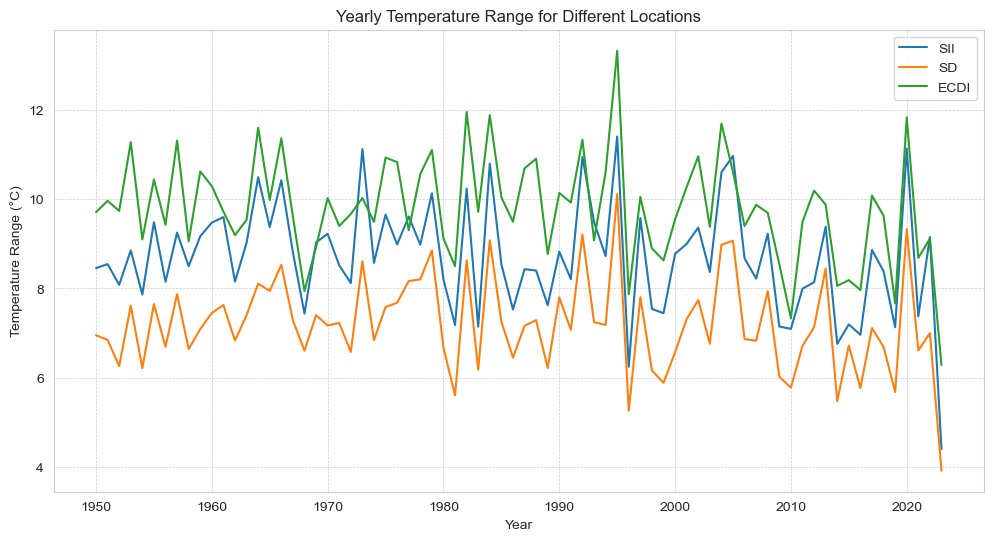

In [11]:
# plot the data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

locations = {
    'SII': {'lat': -53.7202538, 'lon': -72.4763907},
    'SD': {'lat': -54.0692052, 'lon': -71.9549924},
    'ECDI': {'lat': -54.6078561, 'lon': -68.9099137}
}

# plot temperature range for each location on one plot
plt.figure(figsize=(12, 6))
for location, coords in locations.items():
    loc_name = location
    data = pd.read_csv(f'{loc_name}_yearly_temperature_range.csv')
    plt.plot(data.Year, data['year_temperature_range'], label=loc_name)

plt.xlabel('Year')
plt.ylabel('Temperature Range (°C)')
plt.title('Yearly Temperature Range for Different Locations')
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

### Calculating the daily standard deviation of air temperature for each site from 2015 to 2024

In [12]:
locations = {
    'SII': {'lat': -53.7202538, 'lon': -72.4763907},
    'SD': {'lat': -54.0692052, 'lon': -71.9549924},
    'ECDI': {'lat': -54.6078561, 'lon': -68.9099137}
}

for location, coords in locations.items():
    lat = coords['lat']
    lon = coords['lon']
    loc_name = location
    print(f'Fetching data for {loc_name}...')

    for year in range(1950, 2024):
        print(year)
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        fetcher = DataFetcher(lat, lon, start_date, end_date)
        hourly_temp = fetcher.fetch_hourly_variable('temperature_2m')
        hourly_temp['temperature_2m'] = hourly_temp['temperature_2m'] - 273.15

        daily_std_temp = hourly_temp.resample('D').std()
        daily_mean_temp = hourly_temp.resample('D').mean()
        daily_min_temp = hourly_temp.resample('D').min()
        daily_max_temp = hourly_temp.resample('D').max()

        daily_temp_df = pd.concat([daily_mean_temp, daily_min_temp, daily_max_temp, daily_std_temp], axis=1)
        daily_temp_df.columns = ['mean_daily_temperature', 'min_daily_temperature', 'max_daily_temperature', 'std_daily_temperature']

        daily_temp_df.index.names = ['Date']
        daily_temp_df.reset_index(inplace=True)
        daily_temp_df.to_csv(f'{loc_name}_temperature_2m_{year}.csv')

Fetching data for SII...
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
Fetching data for SD...
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
Fetching data for ECDI...
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986


## Loading in and combining all dataframes

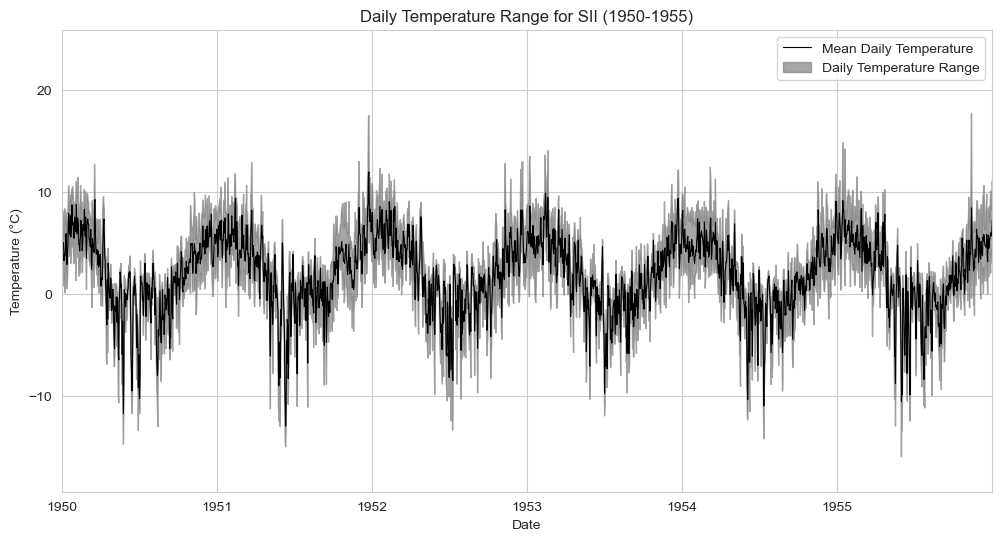

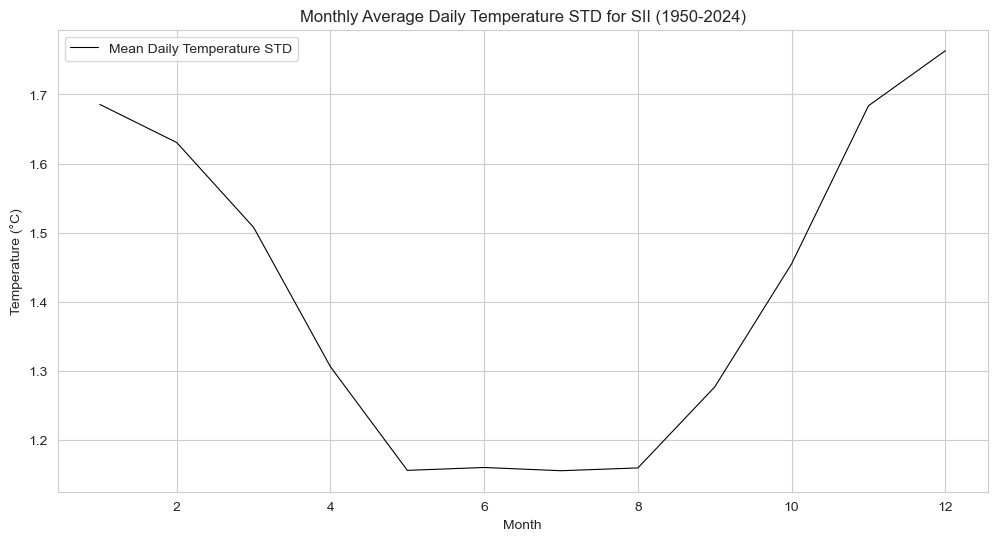

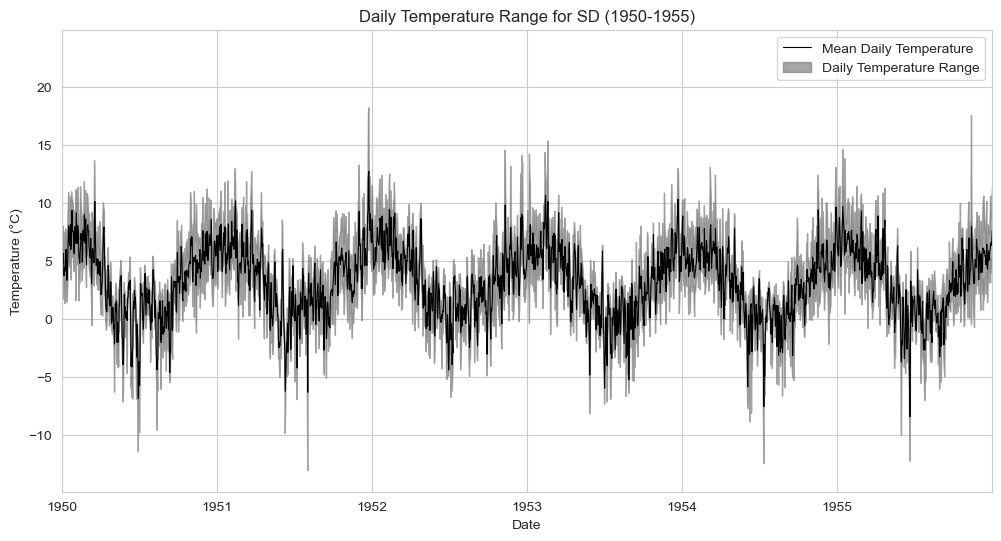

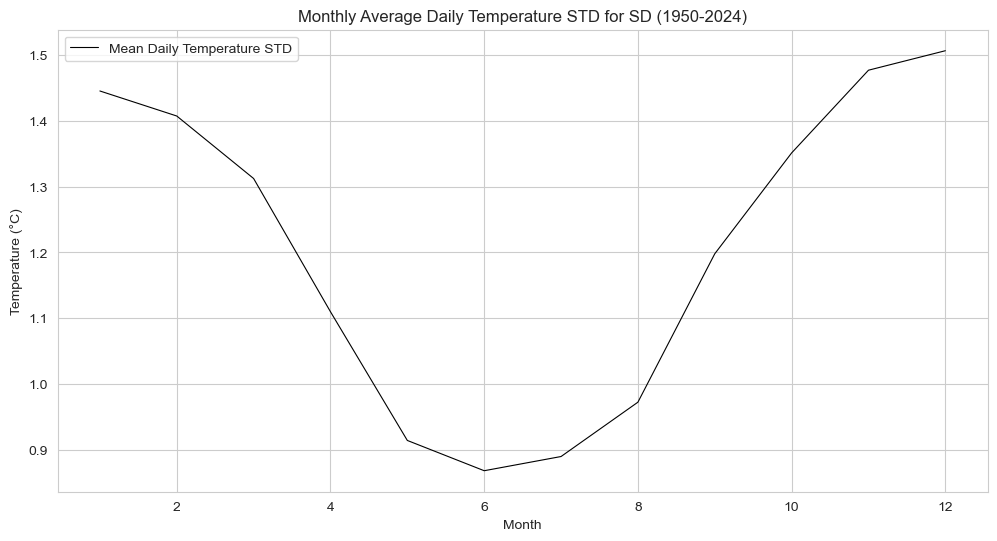

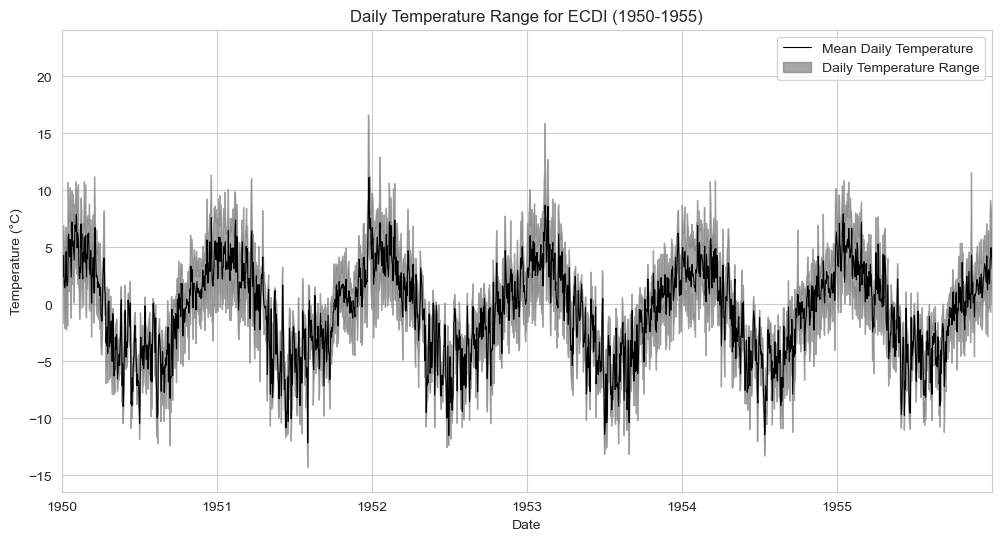

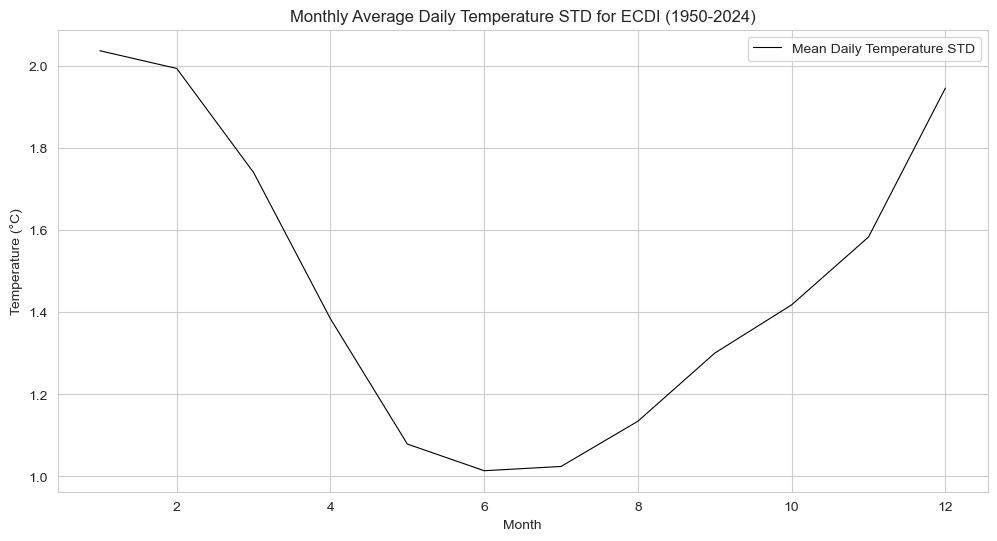

In [42]:
locations = {
    'SII': {'lat': -53.7202538, 'lon': -72.4763907},
    'SD': {'lat': -54.0692052, 'lon': -71.9549924},
    'ECDI': {'lat': -54.6078561, 'lon': -68.9099137}
}

for location, coords in locations.items():
    dfs = []
    for year in range(1950, 2024):
        data = pd.read_csv(f'{location}_temperature_2m_{year}.csv')
        dfs.append(data)

    all_data = pd.concat(dfs)
    all_data['Date'] = pd.to_datetime(all_data['Date'])
    all_data.set_index('Date', inplace=True)

    # plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(all_data.index, all_data['mean_daily_temperature'], label='Mean Daily Temperature', color='k', linewidth=0.8)
    plt.fill_between(all_data.index, all_data['min_daily_temperature'], all_data['max_daily_temperature'], alpha=0.7, label='Daily Temperature Range', color='grey')
    plt.xlabel('Date')
    plt.xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('1955-12-31'))
    plt.ylabel('Temperature (°C)')
    plt.title(f'Daily Temperature Range for {location} (1950-1955)')
    plt.legend()

    # plot average daily std of temperature for each year
    plt.figure(figsize=(12, 6))
    all_data['Month'] = all_data.index.month
    std_data = all_data.groupby('Month')['std_daily_temperature'].mean()
    plt.plot(std_data.index, std_data, label='Mean Daily Temperature STD', color='k', linewidth=0.8)
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Monthly Average Daily Temperature STD for {location} (1950-2024)')
    plt.legend()

    all_data.to_csv(f'{location}_daily_temperature_data.csv')
